In [6]:
%load_ext tensorboard
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda

import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.fftpack import dct
import IPython.display
import librosa

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
%matplotlib inline
import pandas as pd;
import numpy as np
import math
from PIL import Image
from IPython.display import display

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne
import mne.channels
from torchvision.models import mobilenet_v2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model


In [9]:
model = mobilenet_v2()
model.classifier[1] = nn.Linear(1280, 2)
model = nn.Sequential(
    model,
    nn.Softmax(dim=1),
)
model = model.to(device)
model

Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

# Load


In [11]:
model.load_state_dict(torch.load("model_smote_mobilenetv2_secondsuccess.pt"))
model.eval()

Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

# Testing


In [12]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [13]:
%%capture
# Load the dataset
dataset = AbsenceDataset(
    "processed_data/absence/two_second_windows/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [14]:
dataset_len = len(dataset)
dataset_len

8292

In [15]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.1),
            int(dataset_len * 0.7),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 5805
Eval Split: 1658
Test Split: 829
Total: 8292


In [16]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((5805, 5, 500), (5805,))

In [17]:
bk, sz = 0, 0
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 5551 // Absence Seizure: 254


In [20]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(5805, 2500)

In [21]:
train_set_x, train_set_y = SMOTE(
    sampling_strategy="minority", random_state=42
).fit_resample(data_reshaped, train_set.dataset.y[train_set.indices])

In [22]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = eval_set.dataset.x[eval_set.indices]
train_set_x.shape, val_set_x.shape

((11102, 5, 500), (1658, 5, 500))

In [23]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 5551 // Absence Seizure: 5551


In [24]:
n_fft = int(512 / 2)
window = "taylor"
hop_length = int(n_fft / 6)
fmin = 0
fmax = 5
n_mels = 7
sample_rate = 250

# Train
stft_channel_data = []
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
stft_channel_data = np.array(stft_channel_data)

# Val
val_stft_channel_data = []
for i, channels in enumerate(val_set_x):
    val_stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
val_stft_channel_data = np.array(val_stft_channel_data)

stft_channel_data.shape, val_stft_channel_data.shape

((11102, 5, 7, 12), (1658, 5, 7, 12))

In [25]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
val_db = np.array(val_db)

train_db.shape, val_db.shape

((11102, 5, 7, 12), (1658, 5, 7, 12))

In [26]:
# Train
train_db_mean = []
for i, channels in enumerate(stft_channel_data):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_stft_channel_data):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

train_db_mean.shape, val_db_mean.shape

((11102, 7, 12), (1658, 7, 12))

In [27]:
from skimage import io
from sklearn import preprocessing

In [28]:
def sklearn_minnax(min, max, X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [29]:
train_input_x = []
for i, melspec in enumerate(train_db_mean):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    train_input_x.append(img.astype(np.uint8))
train_input_x = np.array(train_input_x)

val_input_x = []
for i, melspec in enumerate(val_db_mean):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    val_input_x.append(img.astype(np.uint8))
val_input_x = np.array(val_input_x)

In [30]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [31]:
train_dataset = BalancedDataset(
    (train_input_x, train_set_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
eval_dataset = BalancedDataset(
    (val_input_x, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

In [32]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=10,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=10, shuffle=True)

In [136]:
for i, v in enumerate(train_dataloader):
    print(v[0][0].shape, v[1][0])
    input_1 = v[0][0].to(device)
    label_1 = v[1][0].to(device)
    break

torch.Size([3, 7, 12]) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(7, 12, 3)


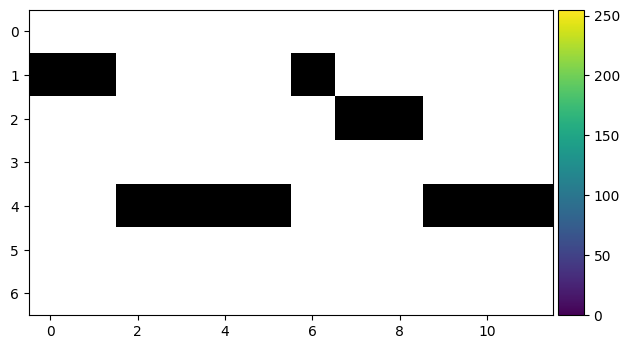

In [137]:
test_sample = input_1.squeeze().cpu()
test_sample = test_sample.numpy()
test_sample = np.transpose(test_sample, (1, 2, 0))
print(test_sample.shape)
io.imshow(test_sample)

In [144]:
result = model(input_1.unsqueeze(0))

In [145]:
result = result.squeeze()
result = result[1]

In [146]:
if result > 0.75:
    print(f"Likely Seizure: %{result * 100}")
elif result > 0.5:
    print(f"Possible Seizure: %{result * 100}")
else:
    print(f"Likely No Seizure: %{result * 100}")

Possible Seizure: %59.32948684692383
